## Import Relevant Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import gensim
import nltk
from nltk.collocations import *
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import RegexpTokenizer 
import pandas as pd

## Import Tweets Data

In [4]:
train_data = pd.read_csv('final_tweets.csv')
train_data

,Datetime,Tweet Id,Text,Username
0,2022-03-04 08:34:06+00:00,1499664468225458180,Regarding this : some statutory board have sel...,JJ_Angelus
1,2022-01-27 09:00:06+00:00,1486625048265834497,Which MBA programme is the best in Singapore? ...,Gyan_One
2,2022-01-27 04:24:15+00:00,1486555627560206336,Pagi ini abis screening hampir 100 CV fresh gr...,Saefullloh
3,2021-12-06 18:06:04+00:00,1467918277884080129,"honestly, really glad i made it to nus bc wthe...",nursyxza
4,2021-09-30 10:10:19+00:00,1443518565466861570,@staronline Does one need training to become a...,PGeorge9601
...,...,...,...,...
553,2011-10-19 06:22:42+00:00,126543777597886464,"Lecturer made some touchy statements, which is...",cxloh
554,2011-06-21 05:51:50+00:00,83049467896532992,Median starting pay for Social Science honours...,leemx
555,2011-05-18 12:32:46+00:00,70829176411787265,We r Singaporean under grad edition. So funny....,punk_hamstar
556,2011-04-28 15:50:34+00:00,63631196717977600,NTU econs vs NUS computing (info sys) vs SMU I...,chaitehlatte


In [5]:
train_text = train_data[['Text']]
train_text

,Text
0,Regarding this : some statutory board have sel...
1,Which MBA programme is the best in Singapore? ...
2,Pagi ini abis screening hampir 100 CV fresh gr...
3,"honestly, really glad i made it to nus bc wthe..."
4,@staronline Does one need training to become a...
...,...
553,"Lecturer made some touchy statements, which is..."
554,Median starting pay for Social Science honours...
555,We r Singaporean under grad edition. So funny....
556,NTU econs vs NUS computing (info sys) vs SMU I...


## Data Cleaning

### Translation

In [6]:
from deep_translator import GoogleTranslator
# to_translate = 'シンガポールの四大新卒初任給、昨年卒の中央値は$3600(約28万円)、it系学部に限ると$4400(約34.5万円)です。\n統計対象の大学はnus、ntu、smu、sussの4大学です'
# translated = GoogleTranslator(source='auto', target='en').translate(to_translate)
# print(translated)

translated_text = []
for i in range(len(train_text)):
#     print(i)
    translated = GoogleTranslator(source='auto', target='en').translate(train_text.iloc[i, 0])
    translated_text.append(translated)
#     print(translated)
#     print(train_text.iloc[i, 0])
print(translated_text)

['Regarding this : some statutory board have selected few public individuals to do the survey. \n\nMy household, was chosen to do them.\n\nIn fact : SMU, NUS, NTU, all have given surveys to public individuals who want to participate.\n\nSo why should our gov release it to the public.', 'Which MBA programme is the best in Singapore? \nIs it the prestigious INSEAD, the much-vaulted NUS, Nanyang (or NTU, as some call it), or the fast-growing SMU? Have similar questions in mind? Check out our blog to get all of your questions answered. https://t.co/UKKRVehonK\n#MBA', 'This morning, after screening almost 100 CV fresh graduates from NTU, NUS, SMU and several polytechnics in Singapore. Surprisingly, there are many graduates from non-IT or engineering related majors, but in their skill set there are Python, Java, C++, Javascript, etc.', 'honestly, really glad i made it to nus bc wtheck smu and ntu module bidding mcm nak perang siak .... aku tengok pun aku stress bodo 😫', "@staronline Does one

In [7]:
train_text['translated'] = translated_text
train_text

C:\Users\jing_\AppData\Local\Temp/ipykernel_10108/947175934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text['translated'] = translated_text


,Text,translated
0,Regarding this : some statutory board have sel...,Regarding this : some statutory board have sel...
1,Which MBA programme is the best in Singapore? ...,Which MBA programme is the best in Singapore? ...
2,Pagi ini abis screening hampir 100 CV fresh gr...,"This morning, after screening almost 100 CV fr..."
3,"honestly, really glad i made it to nus bc wthe...","honestly, really glad i made it to nus bc wthe..."
4,@staronline Does one need training to become a...,@staronline Does one need training to become a...
...,...,...
553,"Lecturer made some touchy statements, which is...","Lecturer made some touchy statements, which is..."
554,Median starting pay for Social Science honours...,Median starting pay for Social Science honours...
555,We r Singaporean under grad edition. So funny....,We r Singaporean under grad edition. So funny....
556,NTU econs vs NUS computing (info sys) vs SMU I...,NTU econs vs NUS computing (info sys) vs SMU i...


In [8]:
print(train_text['translated'][77])

SIM Commits S$50 Million For Startup Incubator, Here’s How It Fares Against Those Of NTU, NUS And SMU https://t.co/36DACIlxso https://t.co/nzfvzplQ9k


### Regex Cleaning

In [9]:
# # train_text['clean'] = train_text['translated'].str.replace(r'@[^\s]+', '')
# train_text['clean'] = train_text['translated'].str.replace(r'https?://\S+', "")
# train_text['clean'] = train_text['clean'].str.replace('\\n', '', regex=True) #remove \n
# train_text['clean'] = train_text['clean'].map(lambda x: x.lower())
# # train_text['Text'].map(lambda x: x.lower())
# # train_text['clean'].values

import re
import emoji
# Define a function to clean the text
def clean(text):
#     print(text)
# Removes all special characters and numericals leaving the alphabets
    
#     text = re.sub('\\n', '')
    text = text.lower()
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'https?://\S+', "", str(text))
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in str(text).split() if not any(i in str for i in emoji_list)])

    return clean_text

# Cleaning the text in the Text column
train_text['cleaned'] = train_text['translated'].apply(clean)
train_text.head()

C:\Users\jing_\AppData\Local\Temp/ipykernel_10108/1513584934.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text['cleaned'] = train_text['translated'].apply(clean)


,Text,translated,cleaned
0,Regarding this : some statutory board have sel...,Regarding this : some statutory board have sel...,regarding this some statutory board have selec...
1,Which MBA programme is the best in Singapore? ...,Which MBA programme is the best in Singapore? ...,which mba programme is the best in singapore i...
2,Pagi ini abis screening hampir 100 CV fresh gr...,"This morning, after screening almost 100 CV fr...",this morning after screening almost cv fresh g...
3,"honestly, really glad i made it to nus bc wthe...","honestly, really glad i made it to nus bc wthe...",honestly really glad i made it to nus bc wthec...
4,@staronline Does one need training to become a...,@staronline Does one need training to become a...,staronline does one need training to become an...


In [10]:
print(train_text['cleaned'][77])

sim commits s million for startup incubator here s how it fares against those of ntu nus and smu


### Stopwords extension

In [11]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['ntu', 'smu', 'sim', 'nus', 'sutd', 'sit', 'suss'])
stop_words.extend(['university', 'universities'])
stop_words.extend(['v', 'vs', 'rt', 'amp', 'n', 'e', 'nd', 'etc', 'pte', 'th', 'h'])
stop_words.extend(['uni', 'u'])
stop_words.extend(['singapore', 'students', 'student', 'schools', 'school', 'sg'])
stop_words.extend(['like', 'go', 'get', 'know', 'see', 'say', 'went', 'going', 'still', 'one', 'got'])
stop_words.extend(['lol', 'haha', 'us', "i'm", 'ah', 'hahaha', 'mdis', 'would', 'also', 'la', 'year'])
stop_words.extend(['calisingapore', 'calichangi', 'calirochester', 'rochester', 'changi', 'cali', 'chelsea', 'arsenal', 'man'])
stop_words.extend(['co', 'bit', 'ly', 'http', 'c', 'b', 'r', 'sunig', 'sian', 'sui', 'ulu', 'peep'])
stop_words.extend(['make', 'want'])

In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet

# stop_words = stopwords.words('english')
# stop_words.extend(['nbsp', 'schoolofinformationsystems', 'smuscis', 'smu', 'sis', 'computingatsmu', 'sgsmu', 'smusis', 'q', 'ly', 'bit'])
# stop_words.extend(['sg', 'like', 'singapore', 'school', 'university', 'scis', 'year', 'student', 'smartcitymanagement', 'computerscience', 'informationsystems'])
print(stop_words)
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stop_words):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

train_text['POS tagged'] = train_text['cleaned'].apply(token_stop_pos)
train_text.head()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

,Text,translated,cleaned,POS tagged
0,Regarding this : some statutory board have sel...,Regarding this : some statutory board have sel...,regarding this some statutory board have selec...,"[(regarding, v), (statutory, a), (board, n), (..."
1,Which MBA programme is the best in Singapore? ...,Which MBA programme is the best in Singapore? ...,which mba programme is the best in singapore i...,"[(mba, n), (programme, n), (best, a), (prestig..."
2,Pagi ini abis screening hampir 100 CV fresh gr...,"This morning, after screening almost 100 CV fr...",this morning after screening almost cv fresh g...,"[(morning, n), (screening, v), (almost, r), (c..."
3,"honestly, really glad i made it to nus bc wthe...","honestly, really glad i made it to nus bc wthe...",honestly really glad i made it to nus bc wthec...,"[(honestly, r), (really, r), (glad, a), (made,..."
4,@staronline Does one need training to become a...,@staronline Does one need training to become a...,staronline does one need training to become an...,"[(staronline, n), (need, n), (training, n), (b..."


### Lematization & POS Tagging

In [13]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

train_text['Lemma'] = train_text['POS tagged'].apply(lemmatize)
train_text.head()

,Text,translated,cleaned,POS tagged,Lemma
0,Regarding this : some statutory board have sel...,Regarding this : some statutory board have sel...,regarding this some statutory board have selec...,"[(regarding, v), (statutory, a), (board, n), (...",regard statutory board select public individ...
1,Which MBA programme is the best in Singapore? ...,Which MBA programme is the best in Singapore? ...,which mba programme is the best in singapore i...,"[(mba, n), (programme, n), (best, a), (prestig...",mba programme best prestigious insead much v...
2,Pagi ini abis screening hampir 100 CV fresh gr...,"This morning, after screening almost 100 CV fr...",this morning after screening almost cv fresh g...,"[(morning, n), (screening, v), (almost, r), (c...",morning screen almost cv fresh graduate seve...
3,"honestly, really glad i made it to nus bc wthe...","honestly, really glad i made it to nus bc wthe...",honestly really glad i made it to nus bc wthec...,"[(honestly, r), (really, r), (glad, a), (made,...",honestly really glad make bc wtheck module b...
4,@staronline Does one need training to become a...,@staronline Does one need training to become a...,staronline does one need training to become an...,"[(staronline, n), (need, n), (training, n), (b...",staronline need training become entrepreneur...


# Network Analysis with Gephi

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

all_text = train_text.Lemma.values.tolist()
# clean_text = ' '.join([str[1] for str in str(text).split() if not any(i in str for i in emoji_list)])

cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english') # You can define your own parameters
X = cv.fit_transform(all_text)

In [42]:
print(all_text)

['  regard statutory board select public individual survey household choose fact give survey public individual participate gov release public', '  mba programme best prestigious insead much vault nanyang call fast grow similar question mind check blog question answer mba', '  morning screen almost cv fresh graduate several polytechnic surprisingly many graduate non engineering related major skill set python java javascript', '  honestly really glad make bc wtheck module bidding mcm nak perang siak aku tengok pun aku stress bodo', '  staronline need training become entrepreneur drnorainiahmad yes include part curriculum might take look do pore officialmosti dradhambaba', '  harddddd doesnt matter psb fuck sake mean hardddd', '  justmyfeeiing good education anywhere local cheap toxic stigma parent employer local bad apply job take second look fucking work hr', '  enough local fill job available infocomm sector alone today job currently remain unfilled min tan really ask top ranked produc

In [43]:
Xc = (X.T * X) # This is the matrix manipulation step
Xc.setdiag(0) # We set the diagonals to be zeroes as it's pointless to be 1

In [44]:
names = cv.get_feature_names() # This are the entity names (i.e. keywords)
df = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
df.to_csv('to gephi.csv', sep = ',')

C:\Users\jing_\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# WordCloud

In [2]:
# print(list(train_text['Text']))
# !pip install stylecloud

     -------------------------------------- 262.1/262.1 KB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 161.4/161.4 KB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 111.8/111.8 KB ? eta 0:00:00
     ---------------------------------------- 87.7/87.7 KB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 87.8/87.8 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for stylecloud: filename=stylecloud-0.5.2-py3-none-any.whl size=259508 sha256=06cb7f33a394434271cef0a421f1ba44ed4d203a7a6f897fc9be3ad81716a5be
  Stored in directory: c:\users\jing_\appdata\local\pip\cache\wheels\89\52\2d\2c5a52800b7bf64bb3c6cf3b59ffab9ad48ef373fcde0a0751
  Created wheel fo

You should consider upgrading via the 'C:\Users\jing_\anaconda3\python.exe -m pip install --upgrade pip' command.


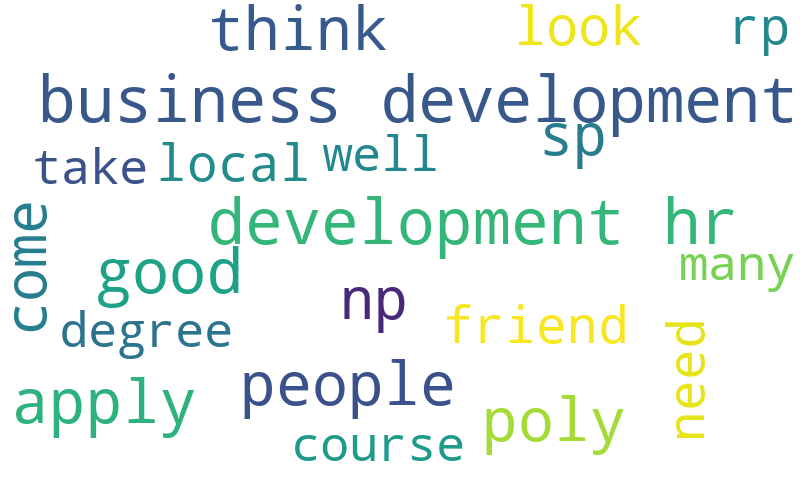

In [59]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(train_text['Lemma']))
# print(long_string)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500, stopwords=stop_words, background_color="white", max_words=20, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [15]:
#Note export for stylecloud

train_text['Lemma'].to_csv('stylecloud text export.csv', index=False)

In [17]:
import stylecloud
stylecloud.gen_stylecloud(file_path = "stylecloud text export.csv", icon_name= "fab fa-twitter")

## Topic Modelling

In [47]:
#convert lemma to tokens 

def tokenize(text):
    new_text = word_tokenize(text)
    return new_text
train_text['lemma_tokens'] = train_text['Lemma'].apply(tokenize)
train_text

,Text,translated,cleaned,POS tagged,Lemma,lemma_tokens
0,Regarding this : some statutory board have sel...,Regarding this : some statutory board have sel...,regarding this some statutory board have selec...,"[(regarding, v), (statutory, a), (board, n), (...",regard statutory board select public individ...,"[regard, statutory, board, select, public, ind..."
1,Which MBA programme is the best in Singapore? ...,Which MBA programme is the best in Singapore? ...,which mba programme is the best in singapore i...,"[(mba, n), (programme, n), (best, a), (prestig...",mba programme best prestigious insead much v...,"[mba, programme, best, prestigious, insead, mu..."
2,Pagi ini abis screening hampir 100 CV fresh gr...,"This morning, after screening almost 100 CV fr...",this morning after screening almost cv fresh g...,"[(morning, n), (screening, v), (almost, r), (c...",morning screen almost cv fresh graduate seve...,"[morning, screen, almost, cv, fresh, graduate,..."
3,"honestly, really glad i made it to nus bc wthe...","honestly, really glad i made it to nus bc wthe...",honestly really glad i made it to nus bc wthec...,"[(honestly, r), (really, r), (glad, a), (made,...",honestly really glad make bc wtheck module b...,"[honestly, really, glad, make, bc, wtheck, mod..."
4,@staronline Does one need training to become a...,@staronline Does one need training to become a...,staronline does one need training to become an...,"[(staronline, n), (need, n), (training, n), (b...",staronline need training become entrepreneur...,"[staronline, need, training, become, entrepren..."
...,...,...,...,...,...,...
553,"Lecturer made some touchy statements, which is...","Lecturer made some touchy statements, which is...",lecturer made some touchy statements which is ...,"[(lecturer, n), (made, v), (touchy, n), (state...",lecturer make touchy statement well,"[lecturer, make, touchy, statement, well]"
554,Median starting pay for Social Science honours...,Median starting pay for Social Science honours...,median starting pay for social science honours...,"[(median, a), (starting, v), (pay, n), (social...",median start pay social science honour grads...,"[median, start, pay, social, science, honour, ..."
555,We r Singaporean under grad edition. So funny....,We r Singaporean under grad edition. So funny....,we r singaporean under grad edition so funny n...,"[(singaporean, a), (grad, a), (edition, n), (f...",singaporean grad edition funny girl leave gu...,"[singaporean, grad, edition, funny, girl, leav..."
556,NTU econs vs NUS computing (info sys) vs SMU I...,NTU econs vs NUS computing (info sys) vs SMU i...,ntu econs vs nus computing info sys vs smu inf...,"[(econs, n), (computing, v), (info, a), (sys, ...",econs compute info sys info sys,"[econs, compute, info, sys, info, sys]"


In [53]:
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
# Create a id2word dictionary
id2word = Dictionary(train_text['lemma_tokens'])
print(len(id2word))
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in train_text['lemma_tokens']]
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

2096
728
------ Topic 0 ------
business graduate job development welcome hr startup fare commits million

------ Topic 1 ------
maincourse uol np tp bar creatingmoments tuition rp sp wine

------ Topic 2 ------
people look friend private poly try new many aiesec graduate

------ Topic 3 ------
business job degree welcome fresh apply hr reject make development

------ Topic 4 ------
degree think next high need sgedu hardtruths diploma utd nanyang



## Sentiment Analysis

In [49]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(tweets):
    return TextBlob(tweets).sentiment.subjectivity
# function to calculate polarity
def getPolarity(tweets):
    return TextBlob(tweets).sentiment.polarity

# function to analyze the tweets
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [50]:
final_data = pd.DataFrame(train_text[['Text', 'Lemma']])
final_data['Subjectivity'] = final_data['Lemma'].apply(getSubjectivity) 
final_data['Polarity'] = final_data['Lemma'].apply(getPolarity) 
final_data['Analysis'] = final_data['Polarity'].apply(analysis)
final_data

,Text,Lemma,Subjectivity,Polarity,Analysis
0,Regarding this : some statutory board have sel...,regard statutory board select public individ...,0.200000,0.000000,Neutral
1,Which MBA programme is the best in Singapore? ...,mba programme best prestigious insead much v...,0.375000,0.350000,Positive
2,Pagi ini abis screening hampir 100 CV fresh gr...,morning screen almost cv fresh graduate seve...,0.380000,0.172500,Positive
3,"honestly, really glad i made it to nus bc wthe...",honestly really glad make bc wtheck module b...,1.000000,0.500000,Positive
4,@staronline Does one need training to become a...,staronline need training become entrepreneur...,0.000000,0.000000,Neutral
...,...,...,...,...,...
553,"Lecturer made some touchy statements, which is...",lecturer make touchy statement well,0.000000,0.000000,Neutral
554,Median starting pay for Social Science honours...,median start pay social science honour grads...,0.066667,0.033333,Positive
555,We r Singaporean under grad edition. So funny....,singaporean grad edition funny girl leave gu...,1.000000,0.250000,Positive
556,NTU econs vs NUS computing (info sys) vs SMU I...,econs compute info sys info sys,0.000000,0.000000,Neutral


In [51]:
print(train_text['POS tagged'].iloc[553])

[('lecturer', 'n'), ('made', 'v'), ('touchy', 'n'), ('statements', 'n'), ('better', 'r')]


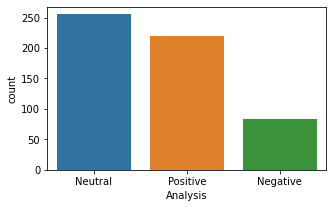

In [52]:
# sentiment_df.plot(kind="bar")
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.countplot(data=final_data, x='Analysis')
plt.show()